# Assignment 27:

### CNN on CIFAR10 
1.  Please visit this link to access the state-of-art DenseNet code for reference - DenseNet - cifar10 notebook link
2.  You need to create a copy of this and "retrain" this model to achieve 90+ test accuracy. 
3.  You cannot use DropOut layers.
4.  You MUST use Image Augmentation Techniques.
5.  You cannot use an already trained model as a beginning points, you have to initilize as your own
6.  You cannot run the program for more than 300 Epochs, and it should be clear from your log, that you have only used 300 Epochs
7.  You cannot use test images for training the model.
8.  You cannot change the general architecture of DenseNet (which means you must use Dense Block, Transition and Output blocks as mentioned in the code)
9.  You are free to change Convolution types (e.g. from 3x3 normal convolution to Depthwise Separable, etc)
10. You cannot have more than 1 Million parameters in total
11. You are free to move the code from Keras to Tensorflow, Pytorch, MXNET etc. 
12. You can use any optimization algorithm you need. 
13. You can checkpoint your model and retrain the model from that checkpoint so that no need of training the model from first if you lost at any epoch while training. You can directly load that model and Train from that epoch. 

In [15]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split


In [16]:
# import keras
# from keras.datasets import cifar10
# from keras.models import Model, Sequential
# from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
# from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from keras.layers import Concatenate
# from keras.optimizers import Adam

from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [17]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [18]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
# X_train, X_cv, y_train, y_cv = train_test_split( X_train, y_train, test_size=0.20, random_state=42)

img_height, img_width, channel = X_train.shape[1], X_train.shape[2], X_train.shape[3]

print('(height, width, channel):({},{},{})'.format(img_height, img_width, channel))
print('train size:', X_train.shape, y_train.shape)
print('test size:', X_test.shape, y_test.shape)
# print('cv size:', X_cv.shape, y_cv.shape)

(height, width, channel):(32,32,3)
train size: (50000, 32, 32, 3) (50000, 1)
test size: (10000, 32, 32, 3) (10000, 1)


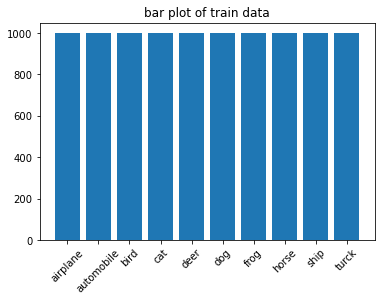

In [19]:
labels = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'turck'}
labels_count = Counter(y_test[:,0])
plt.bar(labels_count.keys(), labels_count.values())
plt.xticks(list(labels.keys()), labels.values(), rotation=45)
plt.title('bar plot of train data');

# Observation: since all the data are balanced

In [20]:
# convert to one hot encoing
num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
# y_cv = tf.keras.utils.to_categorical(y_cv, num_classes)

In [21]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  # featurewise_center=True,
                                  # featurewise_std_normalization=True,
                                  # rotation_range=20,
                                  # width_shift_range=0.2,
                                  # height_shift_range=0.2,
                                  # horizontal_flip=True,
                                  # vertical_flip=True,
                                  
                        )
train_datagenerator = train_datagen.flow(
                            x = X_train,
                            y = y_train,
                        )


test_datagen = ImageDataGenerator(rescale = 1.0/255)
test_datagenerator = test_datagen.flow(
                            x = X_test,
                            y = y_test,
                        )

In [22]:
# Hyperparameters
batch_size = 128
epochs = 10
l = 40
num_filter = 12
compression = 0.5
dropout_rate = 0.2

In [23]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

In [24]:
# model
num_filter = 12
dropout_rate = 0
l = 30

input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False, padding='same')(input)
# ------------------------------------------------------------------------

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

# Fourth_Block = denseblock(Third_Transition, num_filter, dropout_rate)
# Fourth_Transition = transition(Fourth_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)

output = output_layer(Last_Block)


model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_124 (Conv2D)             (None, 32, 32, 12)   324         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_124 (BatchN (None, 32, 32, 12)   48          conv2d_124[0][0]                 
__________________________________________________________________________________________________
activation_124 (Activation)     (None, 32, 32, 12)   0           batch_normalization_124[0][0]    
____________________________________________________________________________________________

__________________________________________________________________________________________________
batch_normalization_233 (BatchN (None, 4, 4, 102)    408         concatenate_225[0][0]            
__________________________________________________________________________________________________
activation_233 (Activation)     (None, 4, 4, 102)    0           batch_normalization_233[0][0]    
__________________________________________________________________________________________________
conv2d_234 (Conv2D)             (None, 4, 4, 6)      5508        activation_233[0][0]             
__________________________________________________________________________________________________
concatenate_226 (Concatenate)   (None, 4, 4, 108)    0           concatenate_225[0][0]            
                                                                 conv2d_234[0][0]                 
__________________________________________________________________________________________________
batch_norm

In [25]:
#https://arxiv.org/pdf/1608.06993.pdf
# from IPython.display import IFrame, YouTubeVideo
# YouTubeVideo(id='-W6y8xnd--U', width=600)

In [26]:
print(len(model.layers))

499


In [27]:
# from tensorflow.keras.utils import plot_model
# plot_model(model, show_shapes=True)

In [28]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

model.fit(train_datagenerator,
          epochs=100,
          verbose=1, 
         )

Train for 1563 steps
Epoch 1/100
1563/1563 [==============================] - 1961s 1s/step - loss: 1.5614 - accuracy: 0.4239
Epoch 2/100
1563/1563 [==============================] - 1919s 1s/step - loss: 1.1430 - accuracy: 0.5923
Epoch 3/100
1563/1563 [==============================] - 1917s 1s/step - loss: 0.9369 - accuracy: 0.6678
Epoch 4/100
1563/1563 [==============================] - 1917s 1s/step - loss: 0.8052 - accuracy: 0.7172
Epoch 5/100
1563/1563 [==============================] - 1916s 1s/step - loss: 0.7059 - accuracy: 0.7524
Epoch 6/100
1563/1563 [==============================] - 1916s 1s/step - loss: 0.6267 - accuracy: 0.7789
Epoch 7/100
1563/1563 [==============================] - 1916s 1s/step - loss: 0.5621 - accuracy: 0.8021
Epoch 8/100
1563/1563 [==============================] - 1917s 1s/step - loss: 0.5043 - accuracy: 0.8231
Epoch 9/100
1563/1563 [==============================] - 1916s 1s/step - loss: 0.4462 - accuracy: 0.8428
Epoch 10/100
1563/1563 [==========

KeyboardInterrupt: 

In [29]:
# Test the model
score = model.evaluate(test_datagenerator, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 118s 378ms/step - loss: 1.3255 - accuracy: 0.7787
Test loss: 1.3254663007804
Test accuracy: 0.7787


In [ ]:
# # Save the trained weights in to .h5 format
# model.save_weights("DNST_model.h5")
# print("Saved model to disk")